In [1]:
import numpy
from matplotlib import pyplot
from sklearn import datasets
from sklearn.model_selection import StratifiedShuffleSplit

## MNIST dataset download

In [2]:
X, y = datasets.fetch_openml('mnist_784', return_X_y=True, as_frame=True, version=1, parser='auto')

## Stratified train test split

In [3]:
ss_splitter = StratifiedShuffleSplit(random_state=69, test_size=0.2, n_splits=1)
train_idx, test_idx = tuple(ss_splitter.split(X, y))[0]
len(train_idx), len(test_idx), len(train_idx) + len(test_idx) == len(X)

(56000, 14000, True)

In [4]:
X_train, y_train = X.iloc[train_idx, :], y[train_idx]
X_test, y_test = X.iloc[test_idx, :], y[test_idx]

## Viz of MNIST dataset

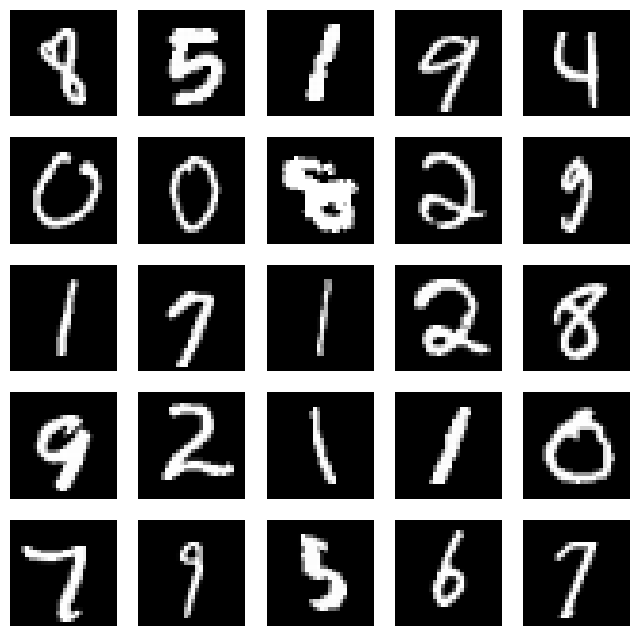

In [5]:
X_train_array = X_train.to_numpy()

images = X_train_array.reshape((-1, 28,28))

fig, axes = pyplot.subplots(nrows=5, ncols=5, figsize=(8,8))

for i in range(5):
    for j in range(5):
        axes[i,j].imshow(images[numpy.random.randint(0, len(images)-1)], cmap='gray')
        axes[i,j].axis('off')
pyplot.show()

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC, LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from transformers import ValuesToFloat

## Preprocessing Pipeline Setup

In [24]:
pipeline = Pipeline(steps=[
    ("values_to_float", ValuesToFloat()),
    ("digit_scalar", StandardScaler()),
    ("perform_lda", LinearDiscriminantAnalysis()),
    ("classify", "passthrough")
])

param_grid = [
    {
        'classify': [SVC(random_state=69)],
        'classify__kernel': ['poly', 'rbf'],
    },
    {
        'classify': [LinearSVC(random_state=69)],
        'classify__loss': ['hinge'],
        'classify__dual': ['auto'],
        'classify__C': [1.0, 10.0, 20.0]
    }
]

## LDA Model training and params search

In [27]:
grid_search = GridSearchCV(pipeline, n_jobs=-1, param_grid=param_grid, scoring='accuracy', cv=3, verbose=4)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('values_to_float', ValuesToFloat()),
                                       ('digit_scalar', StandardScaler()),
                                       ('perform_lda',
                                        LinearDiscriminantAnalysis()),
                                       ('classify', 'passthrough')]),
             n_jobs=-1,
             param_grid=[{'classify': [SVC(random_state=69)],
                          'classify__kernel': ['poly', 'rbf']},
                         {'classify': [LinearSVC(random_state=69)],
                          'classify__C': [1.0, 10.0, 20.0],
                          'classify__dual': ['auto'],
                          'classify__loss': ['hinge']}],
             scoring='accuracy', verbose=4)

## LDA Model best params

In [31]:
grid_search.best_score_, grid_search.best_params_

(0.9126428902510012,
 {'classify': SVC(random_state=69), 'classify__kernel': 'rbf'})

In [35]:
model = grid_search.best_estimator_
test_predictions = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, test_predictions)
classification_rep = classification_report(y_test, test_predictions)

## LDA Performance metrics on test set

In [36]:
print(classification_rep)

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1381
           1       0.95      0.96      0.95      1575
           2       0.90      0.92      0.91      1398
           3       0.89      0.88      0.89      1428
           4       0.90      0.93      0.91      1365
           5       0.86      0.88      0.87      1263
           6       0.94      0.94      0.94      1375
           7       0.94      0.93      0.94      1459
           8       0.88      0.83      0.85      1365
           9       0.91      0.88      0.89      1391

    accuracy                           0.91     14000
   macro avg       0.91      0.91      0.91     14000
weighted avg       0.91      0.91      0.91     14000



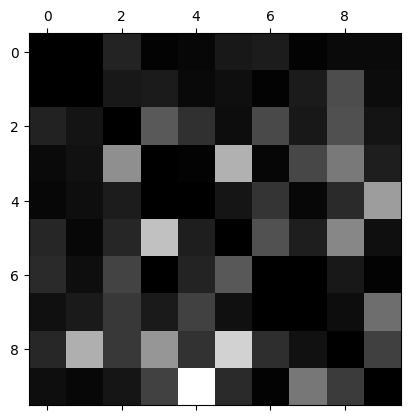

In [39]:
row_sums = conf_matrix.sum(axis=1, keepdims=True)
norm_conf_matrix = conf_matrix / row_sums
numpy.fill_diagonal(norm_conf_matrix, 0)
pyplot.matshow(norm_conf_matrix, cmap=pyplot.cm.gray)

## Train an SVC model using same best params without LDA

In [41]:
svc_model = SVC(random_state=69, kernel='rbf')
std_scalar = StandardScaler()
X_train_transformed = std_scalar.fit_transform(X_train.astype(numpy.float64))
svc_model.fit(X_train_transformed, y_train)

SVC(random_state=69)

## SVC Model Performance metrics

In [42]:
print(classification_report(y_train, svc_model.predict(X_train_transformed)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5522
           1       0.99      0.99      0.99      6302
           2       0.99      0.99      0.99      5592
           3       0.98      0.98      0.98      5713
           4       0.98      0.99      0.99      5459
           5       0.99      0.99      0.99      5050
           6       0.99      0.99      0.99      5501
           7       0.98      0.98      0.98      5834
           8       0.98      0.98      0.98      5460
           9       0.98      0.97      0.98      5567

    accuracy                           0.99     56000
   macro avg       0.99      0.99      0.99     56000
weighted avg       0.99      0.99      0.99     56000



In [43]:
X_test_transformed = std_scalar.transform(X_test)
t_preds = svc_model.predict(X_test_transformed)
print(classification_report(y_test, t_preds))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1381
           1       0.98      0.99      0.98      1575
           2       0.96      0.97      0.96      1398
           3       0.97      0.95      0.96      1428
           4       0.96      0.96      0.96      1365
           5       0.96      0.95      0.96      1263
           6       0.98      0.97      0.97      1375
           7       0.94      0.97      0.96      1459
           8       0.97      0.96      0.96      1365
           9       0.97      0.95      0.96      1391

    accuracy                           0.97     14000
   macro avg       0.97      0.97      0.97     14000
weighted avg       0.97      0.97      0.97     14000



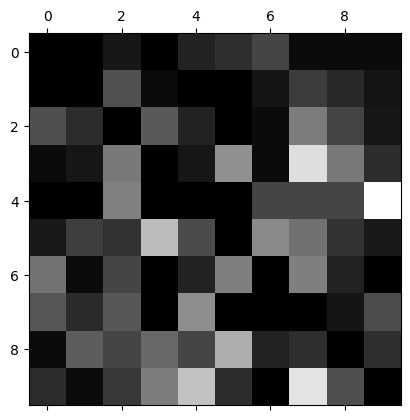

In [44]:
t_conf_mat = confusion_matrix(y_test, t_preds)
row_sums = t_conf_mat.sum(axis=1, keepdims=True)
norm_conf_matrix = t_conf_mat / row_sums
numpy.fill_diagonal(norm_conf_matrix, 0)
pyplot.matshow(norm_conf_matrix, cmap=pyplot.cm.gray)